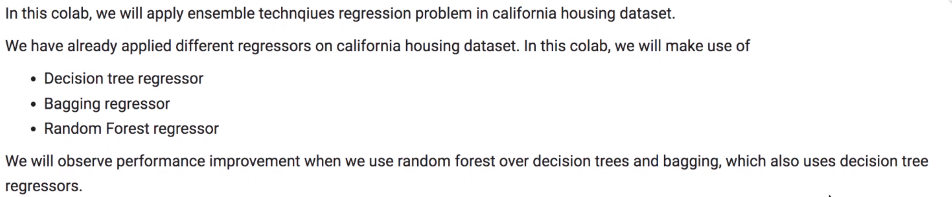

In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import fetch_california_housing

from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit

from sklearn.tree import DecisionTreeRegressor

In [2]:
np.random.seed(306)

In [3]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

In [4]:
# fetch dataset
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)
labels *= 100

# train-test split
com_train_features, test_features, com_train_labels, test_labels = train_test_split(
    features, labels, random_state=42
)

# train --> train + dev-split
train_features, dev_features, train_labels, dev_labels = train_test_split(
    com_train_features, com_train_labels, random_state=42
)

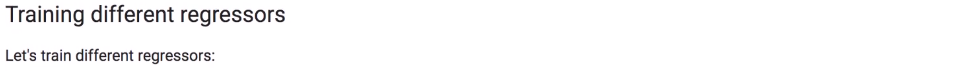

In [5]:
def train_regressor(estimator, X_train, y_train, cv, name):
    cv_results = cross_validate(
        estimator,
        X_train,
        y_train,
        cv=cv,
        scoring='neg_mean_absolute_error',
        return_train_score=True,
        return_estimator=True
    )
    
    cv_train_error = -1 * cv_results['train_score']
    cv_test_error = -1 * cv_results['test_score']    
    
    print(f'On an average, {name} makes an error of '
      f'{cv_train_error.mean():.3f}k +/- {cv_train_error.std():.3f}k on the training set.')
    print(f'On an average, {name} makes an error of '
      f'{cv_test_error.mean():.3f}k +/- {cv_test_error.std():.3f}k on the test set.')

In [8]:
#@title Decision Tree Regressor
train_regressor(
    DecisionTreeRegressor(),
    com_train_features,
    com_train_labels,
    cv,
    '*Decision Tree Regressor*'
)

On an average, *Decision Tree Regressor* makes an error of 0.000k +/- 0.000k on the training set.
On an average, *Decision Tree Regressor* makes an error of 47.456k +/- 1.125k on the test set.


In [9]:
#@title Bagging Regressor
train_regressor(
    BaggingRegressor(),
    com_train_features,
    com_train_labels,
    cv,
    '*Bagging Regressor*'
)

On an average, *Bagging Regressor* makes an error of 14.453k +/- 0.167k on the training set.
On an average, *Bagging Regressor* makes an error of 35.373k +/- 0.943k on the test set.


In [10]:
#@title Random Forest Regressor
train_regressor(
    RandomForestRegressor(),
    com_train_features,
    com_train_labels,
    cv,
    '*Random Forrest Regressor*'
)

On an average, *Random Forrest Regressor* makes an error of 12.654k +/- 0.070k on the training set.
On an average, *Random Forrest Regressor* makes an error of 33.208k +/- 0.710k on the test set.


In [11]:
param_distributions = {
    'n_estimators': [1, 2, 5, 10, 20, 50, 100, 200, 500],
    'max_leaf_nodes': [2, 5, 10, 20, 50, 100]
}

search_cv = RandomizedSearchCV(
    RandomForestRegressor(n_jobs=2),
    param_distributions=param_distributions,
    scoring='neg_mean_absolute_error',
    n_iter=10,
    random_state=0,
    n_jobs=2
)

search_cv.fit(com_train_features, com_train_labels)

columns = [f'param_{name}' for name in param_distributions.keys()]
columns+= ['mean_test_error', 'std_test_error']
cv_results = pd.DataFrame(search_cv.cv_results_)
cv_results['mean_test_error'] = -cv_results['mean_test_score']
cv_results['std_test_error'] = cv_results['std_test_score']
cv_results[columns].sort_values(by='mean_test_error')

,param_n_estimators,param_max_leaf_nodes,mean_test_error,std_test_error
0,500,100,40.605110,0.806879
2,10,100,41.190592,1.003263
7,100,50,43.834640,0.838267
8,1,100,46.987839,0.804174
1,100,20,49.359117,1.032891
6,50,20,49.633525,1.223093
9,10,20,49.870691,1.256653
3,500,10,55.024207,1.067682
4,5,5,61.481587,0.703319
5,5,2,73.250895,1.187768


In [12]:
error = -search_cv.score(test_features, test_labels)
print(f'On average, Random Forest Regressor makes an error of {error:.2f}k')

On average, Random Forest Regressor makes an error of 40.47k
